In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

# Optimization and Bayesian Optimization libraries
import torch
from botorch.utils.transforms import normalize, unnormalize
from boclass_aqui import PoolObjectives, Models

import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double


cpu


In [2]:
all_data = pd.read_csv('../all_data.csv') # all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)
all_data = all_data[:15]

# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)

x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=dtype, device=device)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=dtype, device=device)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=dtype, device=device)

seed = 42
random.seed(seed)
train_size = 2
random_indices = random.sample(range(x_all.shape[0]), train_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train = y_all[random_indices]
y_train_var = yvar_all[random_indices]

# Set up the Pool
x_train_np = x_train.cpu().numpy()
# Find all rows in x_inputs that are not in x_train
mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]

# Set up the Gaussian Process and query
query = PoolObjectives(x_input_new, y_output_new ,yvar_output_new, columns=['time', 'temp', 'sulf', 'anly'])
# Step 1: Initialize your model
EI_model = Models(aqui_func='EI', x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=1, objective=query)
UCB_model = Models(aqui_func='UCB', x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=1, objective=query)
PI_model = Models(aqui_func='PI', x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=1, objective=query)


In [3]:
# Generate a 4D test_x grid within the normalized bounds [0, 1] for each dimension
num_points_per_dim = 10
grid_axes = [np.linspace(0, 1, num_points_per_dim) for _ in range(4)]
mesh = np.meshgrid(*grid_axes, indexing='ij')
test_x = np.stack([m.flatten() for m in mesh], axis=-1)
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)


def BO_loop(seed, aqui_func,gp_model, x_all, y_all, yvar_all,iterations=5):
    random.seed(seed)
    train_size = 2
    x_pool = torch.tensor(x_inputs.to_numpy(), dtype=dtype, device=device)
    y_pool = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=dtype, device=device)
    yvar_pool = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=dtype, device=device)
    random_indices = random.sample(range(x_pool.shape[0]), train_size)
    x_train = x_pool[random_indices]
    train_nx = normalize(x_train, bounds=original_bounds) # normalized data for training
    train_y = y_pool[random_indices]
    train_yvar = yvar_pool[random_indices]


    query = PoolObjectives(x_all, y_all, yvar_all, columns=['time', 'temp', 'sulf', 'anly'])

    varsum_store = [gp_model.gp_evaluate(test_x, 'Regular')[1].sum().item()]
    rmse_store = [np.sqrt(np.mean((gp_model.gp_evaluate(test_x, 'Regular')[0].sum().item()- y_all) ** 2)).item()]
    best_y_store = [train_y.max().item()]

    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.regular_candidates()
        
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)
        

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)

        # Instantiate and train updated model
        gp_model = Models(aqui_func=aqui_func, x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=1, objective=query, random_id = seed )

        # Metrics evaluation
        _, test_var = gp_model.gp_evaluate(test_x, 'Regular')
        test_mean,_ = gp_model.gp_evaluate(torch.tensor(x_all.to_numpy()), 'Regular')
        var_sum = test_var.sum().item()
        rmse = np.sqrt(np.mean((test_mean - y_all.to_numpy()) ** 2)).item()
        varsum_store.append(var_sum)
        rmse_store.append(rmse)
        best_y_store.append(train_y.max().item())
    return gp_model, train_nx, train_y, best_y_store, np.array(varsum_store), np.array(rmse_store) # returns the final model, all trian data, and evaluated test mean and variance per rounds


In [4]:
num = 10
iter_count = 15-train_size
EI_var_sum = []
UCB_var_sum = []
PI_var_sum = []
EI_rmse = []
UCB_rmse = []
PI_rmse = []
EI_y_all = []
UCB_y_all = []
PI_y_all = []
for seed in range(num):
    ExpImp, EI_x, EI_y,EI_ybest, EIvar_sum, EIrmse = BO_loop(seed, 'EI',EI_model,  x_input_new, y_output_new, yvar_output_new,iterations=iter_count)
    UppCB, UCB_x, UCB_y, UCB_ybest, UCBvar_sum, UCBrmse = BO_loop(seed, 'UCB',UCB_model, x_input_new, y_output_new, yvar_output_new,iterations=iter_count)
    ProbImp, PI_x, PI_y, PI_ybest,  PIvar_sum, PIrmse = BO_loop(seed, 'PI',PI_model, x_input_new, y_output_new, yvar_output_new,iterations=iter_count)
    # Store the results
    EI_var_sum.append(EIvar_sum)
    UCB_var_sum.append(UCBvar_sum)
    PI_var_sum.append(PIvar_sum)
    EI_rmse.append(EIrmse)
    UCB_rmse.append(UCBrmse)
    EI_y_all.append(EI_ybest)
    UCB_y_all.append(UCB_ybest)
    PI_y_all.append(PI_ybest)


In [5]:
EI_var_sum = np.array(EI_var_sum)
UCB_var_sum = np.array(UCB_var_sum)
PI_var_sum = np.array(PI_var_sum)
EI_rmse = np.array(EI_rmse)
UCB_rmse = np.array(UCB_rmse)
PI_rmse = np.array(PI_rmse)
EI_y_all = np.array(EI_y_all)
UCB_y_all = np.array(UCB_y_all)
PI_y_all = np.array(PI_y_all)

EI_var_sum.mean(axis=0), EI_var_sum.mean(axis=0)

(array([  33.65724175, 1413.04845591, 1135.29133379, 1001.52297866,
         733.85408411,  540.61991006,  471.81196397,  382.39337653,
         393.27753903,  303.7080802 ,  220.47817689,  197.15393803,
         163.48719748,  155.36371266]),
 array([  33.65724175, 1413.04845591, 1135.29133379, 1001.52297866,
         733.85408411,  540.61991006,  471.81196397,  382.39337653,
         393.27753903,  303.7080802 ,  220.47817689,  197.15393803,
         163.48719748,  155.36371266]))

# plots

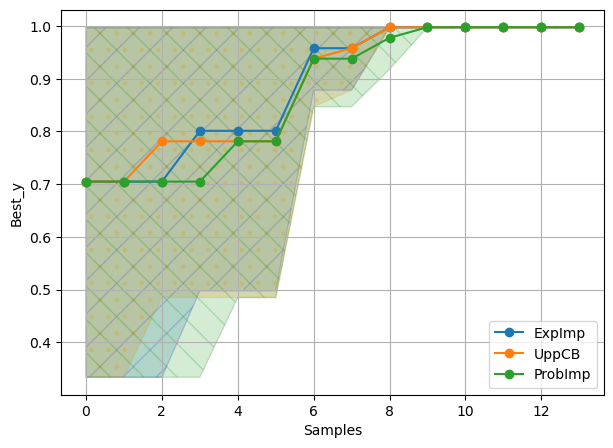

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(EI_y_all.mean(axis=0))),  (EI_y_all.mean(axis=0)), marker='o', label='ExpImp', alpha=1.0)
EI_fill = plt.fill_between(
    range(len(EI_y_all.std(axis=0))),
    (EI_y_all.mean(axis=0) - EI_y_all.std(axis=0)),
    np.minimum(EI_y_all.mean(axis=0) + EI_y_all.std(axis=0), .997),
    alpha=0.2,
    hatch='/',
    edgecolor='blue'
)
plt.plot(range(len(UCB_y_all.mean(axis=0))), (UCB_y_all.mean(axis=0)), marker='o', label='UppCB', alpha=1.0)
UCB_fill = plt.fill_between(
    range(len(UCB_y_all.std(axis=0))),
    (UCB_y_all.mean(axis=0) - UCB_y_all.std(axis=0)),
    np.minimum(UCB_y_all.mean(axis=0) + UCB_y_all.std(axis=0), 0.997),
    alpha=0.2,
    hatch='.',
    edgecolor='orange'
)
# # Add a fill pattern (hatch) to the fill_between area
# for collection in UCB_fill.get_paths():
#     # Set hatch and color for the fill_between area
#     UCB_fill .set_hatch('.')
#     UCB_fill .set_facecolor('green')
plt.plot(range(len(PI_y_all.mean(axis=0))),  (PI_y_all.mean(axis=0)), marker='o', label='ProbImp', alpha=1.0)
plt.fill_between(
    range(len(PI_y_all.std(axis=0))),
    (PI_y_all.mean(axis=0) - PI_y_all.std(axis=0)),
    np.minimum(PI_y_all.mean(axis=0) + PI_y_all.std(axis=0), .997),
    alpha=0.2, 
    hatch='\\',
    edgecolor='green'
)

plt.xlabel('Samples')
plt.ylabel('Best_y')
# plt.title('Expected Improvement (EI_y) vs Iterations')
plt.grid(True)
plt.legend()
plt.show()

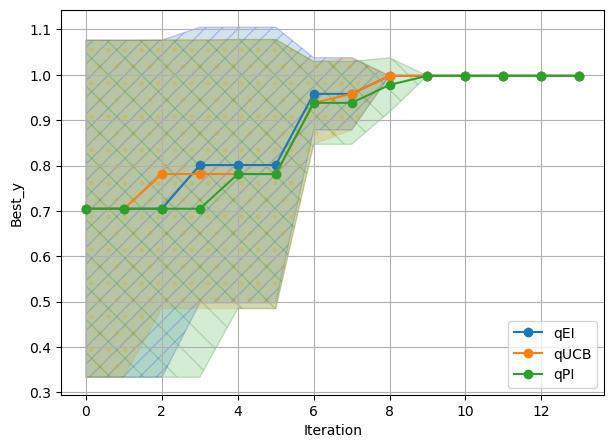

In [7]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(EI_y_all.mean(axis=0))),  (EI_y_all.mean(axis=0)), marker='o', label='qEI', alpha=1.)
plt.fill_between(range(len(EI_y_all.std(axis=0))),
                 (EI_y_all.mean(axis=0) - EI_y_all.std(axis=0)),
                 (EI_y_all.mean(axis=0) + EI_y_all.std(axis=0)), alpha=0.2, hatch='//', edgecolor='blue')
plt.plot(range(len(UCB_y_all.mean(axis=0))), (UCB_y_all.mean(axis=0)), marker='o', label='qUCB', alpha=1.)
plt.fill_between(range(len(UCB_y_all.std(axis=0))),
                 (UCB_y_all.mean(axis=0) - UCB_y_all.std(axis=0)),
                 (UCB_y_all.mean(axis=0) + UCB_y_all.std(axis=0)), alpha=0.2, hatch='.', edgecolor='orange'
                 )
plt.plot(range(len(PI_y_all.mean(axis=0))),  (PI_y_all.mean(axis=0)), marker='o', label='qPI', alpha=1.)
plt.fill_between(range(len(PI_y_all.std(axis=0))),
                 (PI_y_all.mean(axis=0) - PI_y_all.std(axis=0)),
                 (PI_y_all.mean(axis=0) + PI_y_all.std(axis=0)), alpha=0.2,hatch='\\',edgecolor='green'
                 )

plt.xlabel('Iteration')
plt.ylabel('Best_y')
# plt.title('Expected Improvement (EI_y) vs Iterations')
plt.grid(True)
plt.legend()
plt.show()

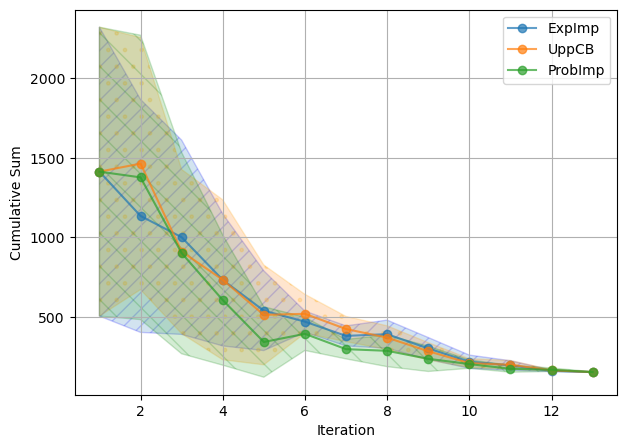

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(1,  len(EI_y) - 1)[:], (EI_var_sum.mean(axis = 0)[1:]), marker='o', label='qEI', alpha=0.7)
plt.fill_between(range(1, len(EI_y) -1)[:],
                 (EI_var_sum.mean(axis = 0)[1:] - EI_var_sum.std(axis = 0)[1:]),
                 (EI_var_sum.mean(axis = 0)[1:] + EI_var_sum.std(axis = 0)[1:]), alpha=0.2, hatch='//',edgecolor='blue')
plt.plot(range(1, len(UCB_y) - 1)[:], (UCB_var_sum.mean(axis = 0)[1:]), marker='o', label='qUCB', alpha=0.7)
plt.fill_between(range(1,  len(UCB_y) - 1)[:],
                 (UCB_var_sum.mean(axis = 0)[1:] - UCB_var_sum.std(axis = 0)[1:]),
                 (UCB_var_sum.mean(axis = 0)[1:] + UCB_var_sum.std(axis = 0)[1:]), alpha=0.2, hatch='.',edgecolor='orange')
plt.plot(range(1,  len(PI_y) - 1)[:], (PI_var_sum.mean(axis = 0)[1:]), marker='o', label='qPI', alpha=0.7)
plt.fill_between(range(1, len(PI_y) - 1)[:],
                 (PI_var_sum.mean(axis = 0)[1:] - PI_var_sum.std(axis = 0)[1:]),
                 (PI_var_sum.mean(axis = 0)[1:] + PI_var_sum.std(axis = 0)[1:]), alpha=0.2,hatch='\\',edgecolor='green')

plt.xlabel('Iteration')
plt.ylabel('Cumulative Sum')
# plt.title('Expected Improvement (EI_y) vs Iterations')
plt.grid(True)
plt.legend()
plt.show()